### Project Name - Telecom Churn Prediction
### Team 5 - Harsh Yadav, Hosang, Simranjeet
Dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data

# Importing the required libraries

In [1]:
#import the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.ticker as mtick  
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, SimpleRNN
from keras.optimizers import Adam
from keras.regularizers import l2
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
#importing csv
telco_base_data = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
telco_base_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**The data set includes information about:** <br>

Customers who left within the last month – the column is called Churn <br>

Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies <br>

Customer account information - how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges <br>

Demographic info about customers – gender, age range, and if they have partners and dependents <br>

In [5]:
telco_base_data.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [6]:
# Checking the data types of all the columns
telco_base_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
telco_base_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


1. SeniorCitizen is actually a categorical hence the 25%-50%-75% distribution is not propoer

2. 75% customers have tenure less than 55 months

3. Average Monthly charges are USD 64.76 whereas 25% customers pay more than USD 89.85 per month

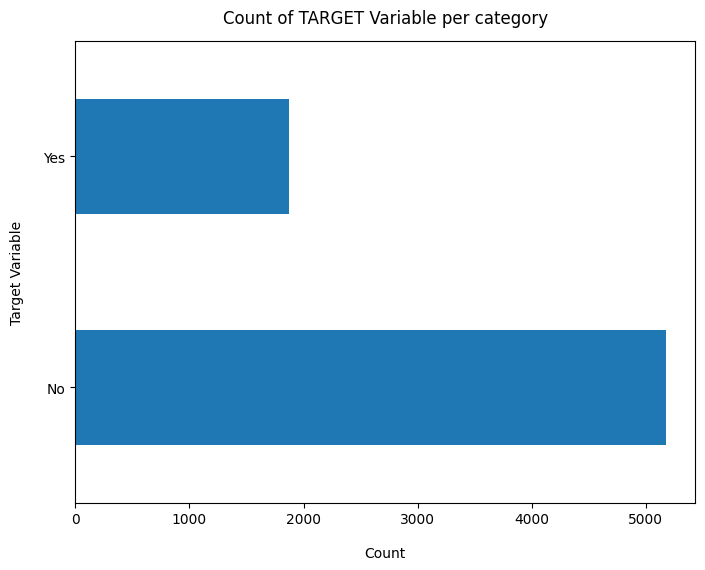

In [8]:
telco_base_data['Churn'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

In [9]:
telco_base_data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [10]:
100*telco_base_data['Churn'].value_counts()/len(telco_base_data['Churn'])

Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64

1. Data is highly imbalanced, ratio = 73:27
2. So we analyse the data with other features while taking the target values separately to get some insights.

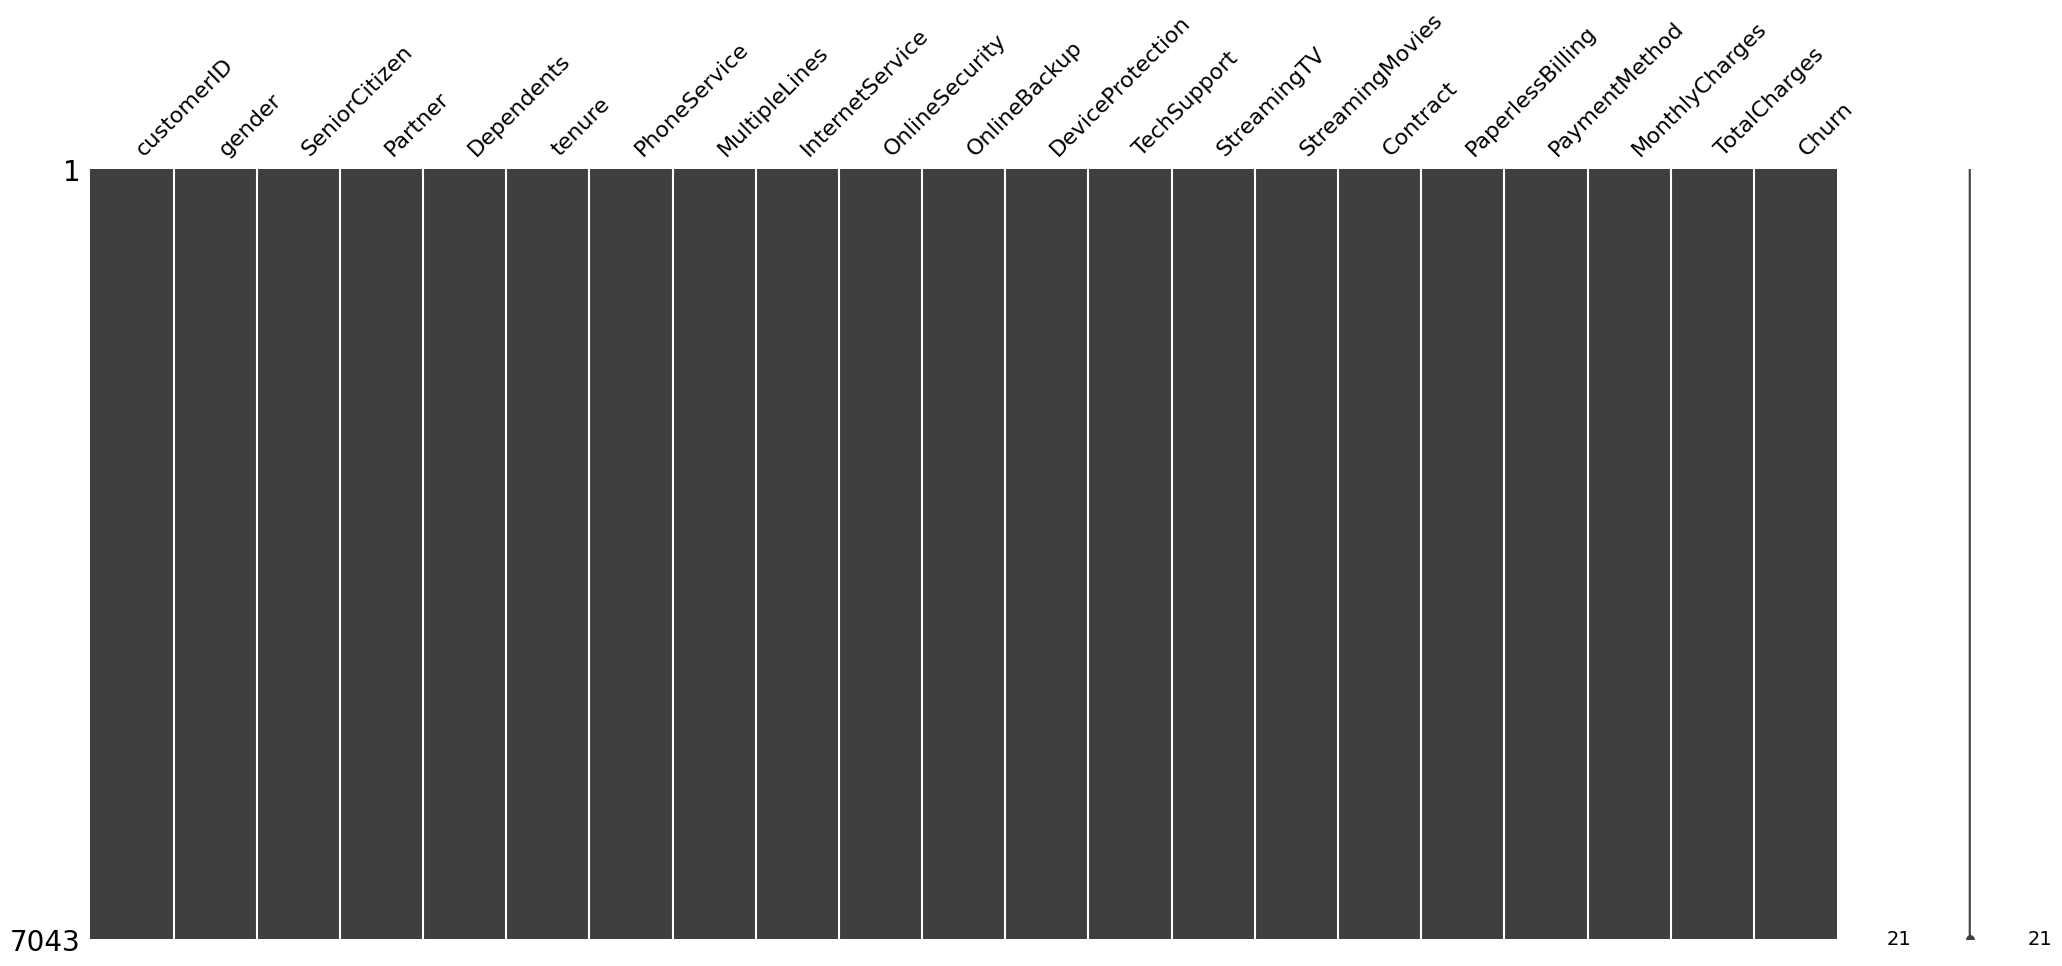

In [11]:
#checking the missing values
import missingno as msno
msno.matrix(telco_base_data);

Here, we can clearly see that there are no missing values. <br>
**General Thumb Rules:**
For features with less missing values- can use regression to predict the missing values or fill with the mean of the values present, depending on the feature.

# Data Cleaning

1. Create a copy of base data for manupulation & processing

In [12]:
telco_data = telco_base_data.copy()

2. Total Charges should be numeric amount. Let's convert it to numerical data type

In [13]:
telco_data.TotalCharges = pd.to_numeric(telco_data.TotalCharges, errors='coerce')
telco_data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

So, here we can see that somehow there are 11 missing values in totalchanges. <br>
Now, let's have a look there

**Missing Value Treatement**

3. As we can see there are 11 missing values in TotalCharges column. Let's check these records



In [14]:
telco_data.loc[telco_data ['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


4. Since the % of these records compared to total dataset is very low ie 0.15%, it is safe to ignore them from further processing.

In [15]:
#Removing missing values 
telco_data.dropna(how = 'any', inplace = True)

In [16]:
telco_data.loc[telco_data ['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


5. Divide customers into bins based on tenure e.g. for tenure < 12 months: assign a tenure group if 1-12, for tenure between 1 to 2 Yrs, tenure group of 13-24; so on...

In [17]:
# Get the max tenure
print(telco_data['tenure'].max()) 

72


In [18]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]
telco_data['tenure_group'] = pd.cut(telco_data.tenure, range(1, 80, 12), right=False, labels=labels)
telco_data['tenure_group'].value_counts()

tenure_group
1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: count, dtype: int64

6. Remove columns not required for processing

In [19]:
#drop column customerID and tenure
telco_data.drop(columns= ['customerID','tenure'], axis=1, inplace=True)
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


**Convert the target variable 'Churn' in a binary numeric variable i.e. Yes=1 ; No = 0**

In [20]:
telco_data['Churn'] = np.where(telco_data.Churn == 'Yes',1,0)
telco_data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 - 12
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 - 12


Convert all the categorical variables into dummy variables

In [21]:
telco_data_dummies = pd.get_dummies(telco_data)
telco_data_dummies.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,0,True,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
1,0,56.95,1889.50,0,False,True,True,False,True,False,...,False,False,False,True,False,False,True,False,False,False
2,0,53.85,108.15,1,False,True,True,False,True,False,...,False,False,False,True,True,False,False,False,False,False
3,0,42.30,1840.75,0,False,True,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4,0,70.70,151.65,1,True,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,False


# Data Exploration

 Relationship between Monthly Charges and Total Charges

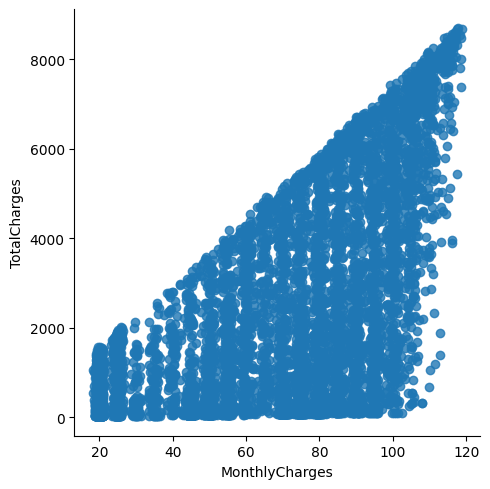

In [22]:
sns.lmplot(data=telco_data_dummies, x='MonthlyCharges', y='TotalCharges', fit_reg=False)

Total Charges increase as Monthly Charges increase - as expected.

**Churn by Monthly Charges and Total Charges**

Text(0.5, 1.0, 'Monthly charges by churn')

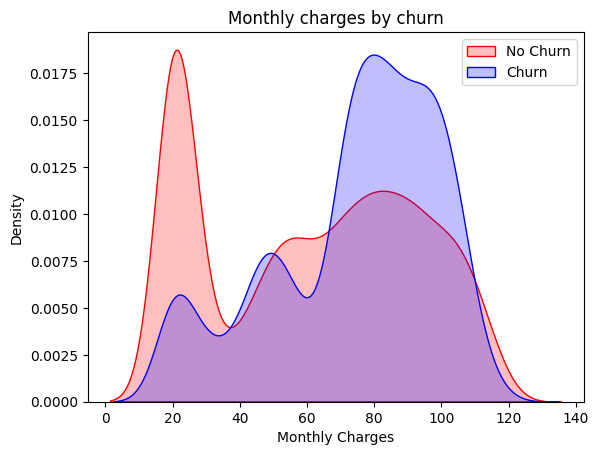

In [23]:
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 0) ],
                color="Red", shade = True)
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 1) ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

**Insight**: Churn is high when Monthly Charges ar high

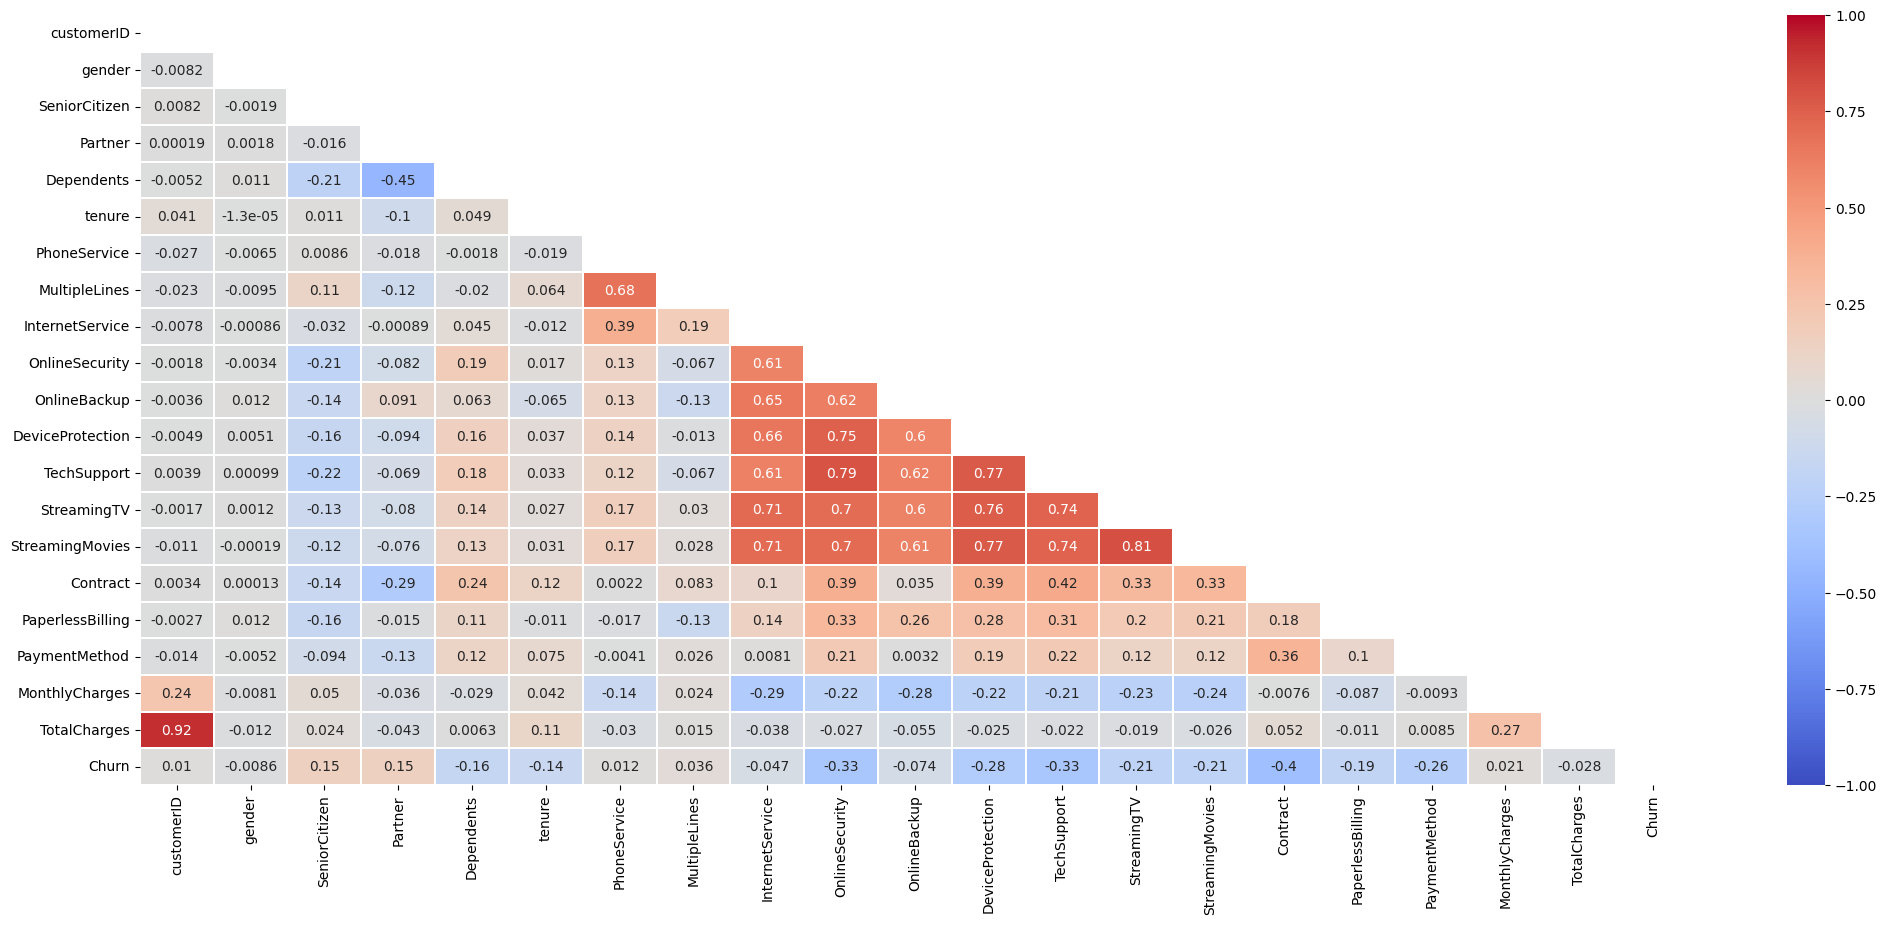

In [24]:
plt.figure(figsize=(25, 10))

corr = telco_base_data.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

**Low Correlation:** Most attributes have low correlation as indicated by the lighter colors. This suggests that most of these customer attributes do not strongly influence each other.
**High Correlation:** There are stronger positive correlations visible among attributes like “MonthlyCharges” and “TotalCharges”, depicted in darker red. This suggests that as the monthly charges increase, the total charges also increase, which is an expected relationship.

### Bivariate Analysis

In [25]:
new_df1_target0=telco_data.loc[telco_data["Churn"]==0]
new_df1_target1=telco_data.loc[telco_data["Churn"]==1]

In [26]:
def uniplot(df,col,title,hue =None):
    
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright') 
        
    plt.show()

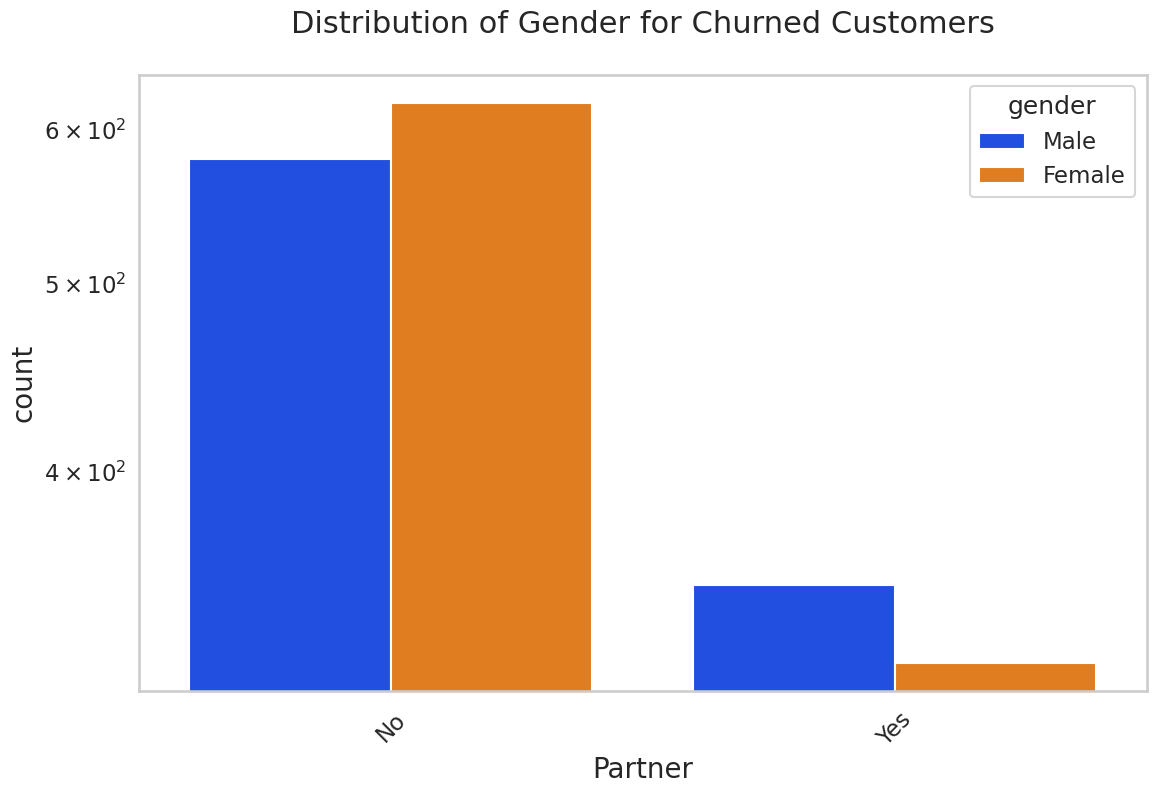

In [27]:
uniplot(new_df1_target1,col='Partner',title='Distribution of Gender for Churned Customers',hue='gender')

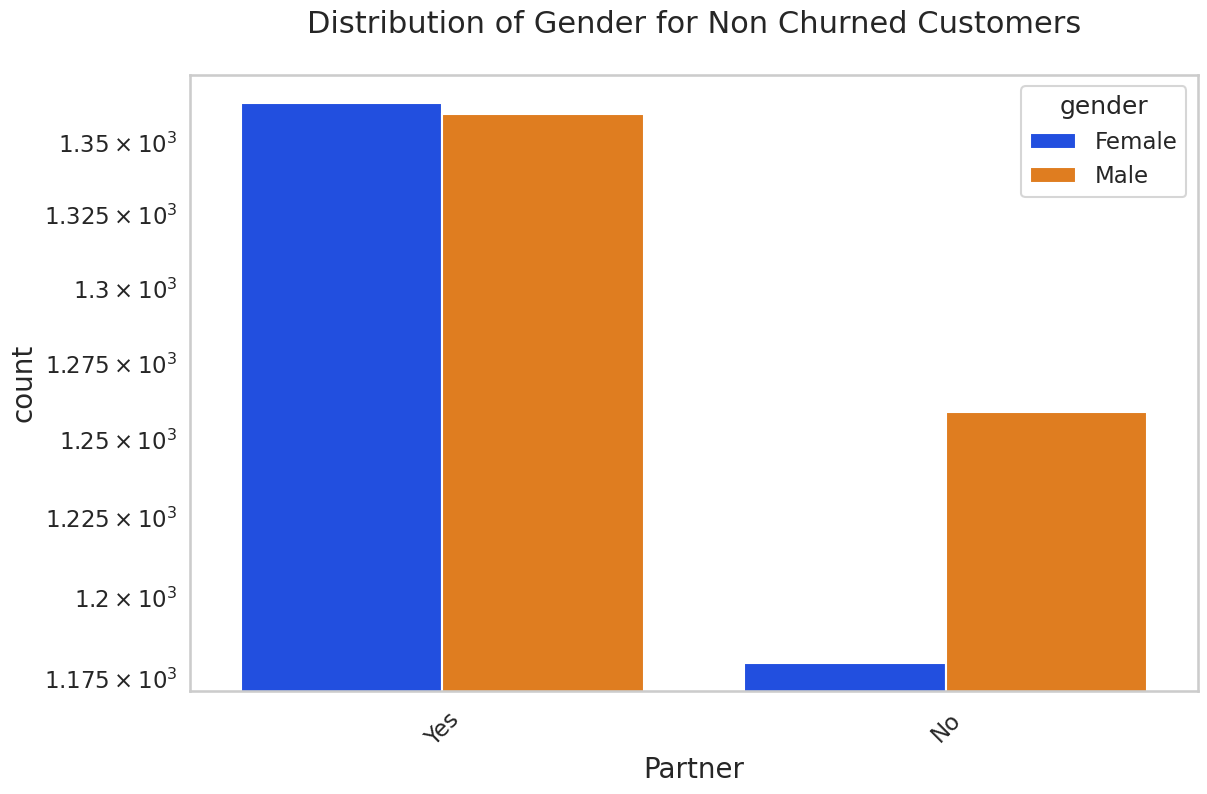

In [28]:
uniplot(new_df1_target0,col='Partner',title='Distribution of Gender for Non Churned Customers',hue='gender')

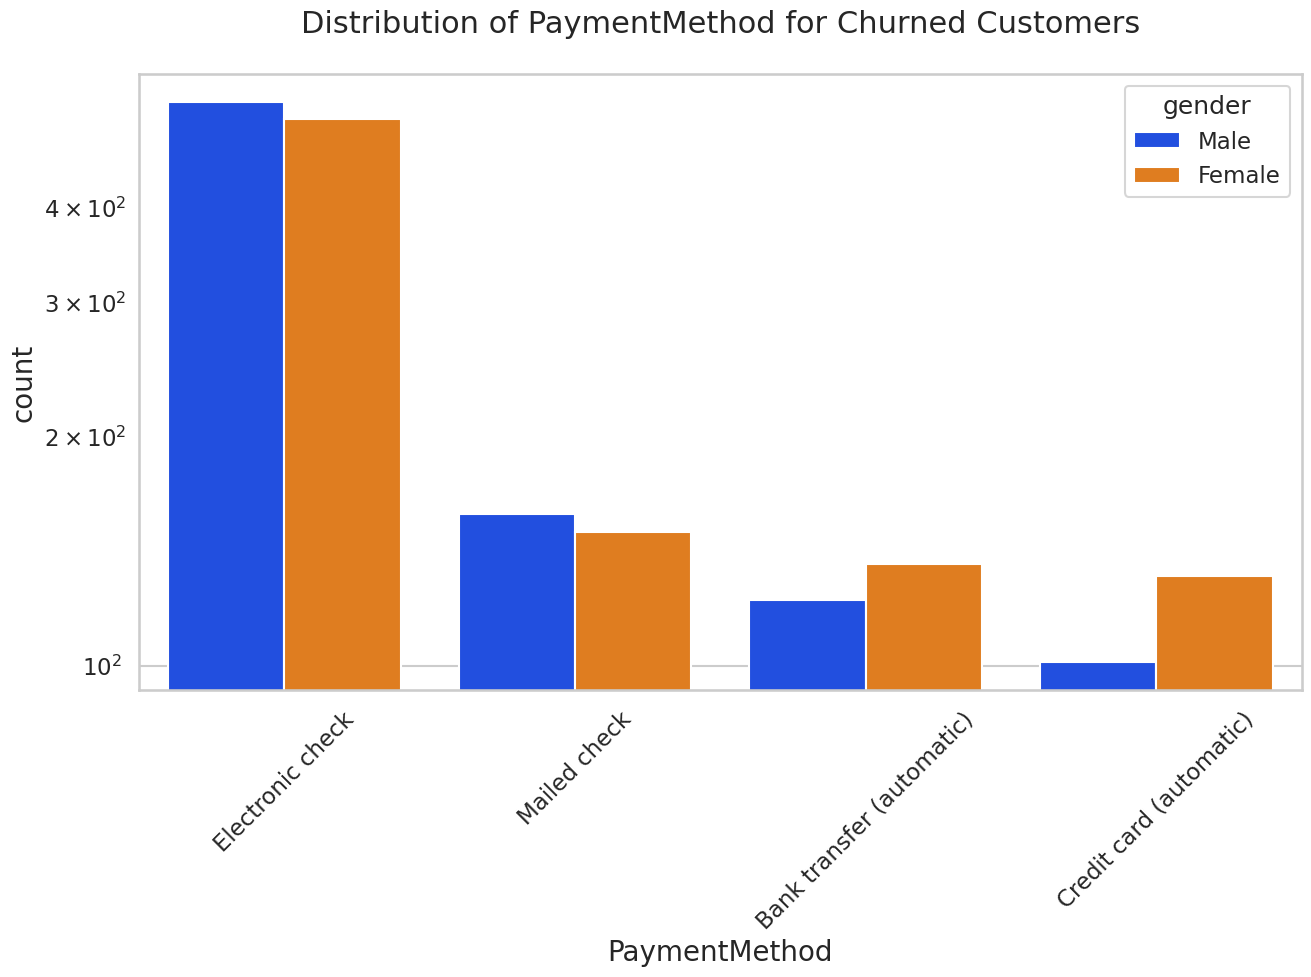

In [29]:
uniplot(new_df1_target1,col='PaymentMethod',title='Distribution of PaymentMethod for Churned Customers',hue='gender')

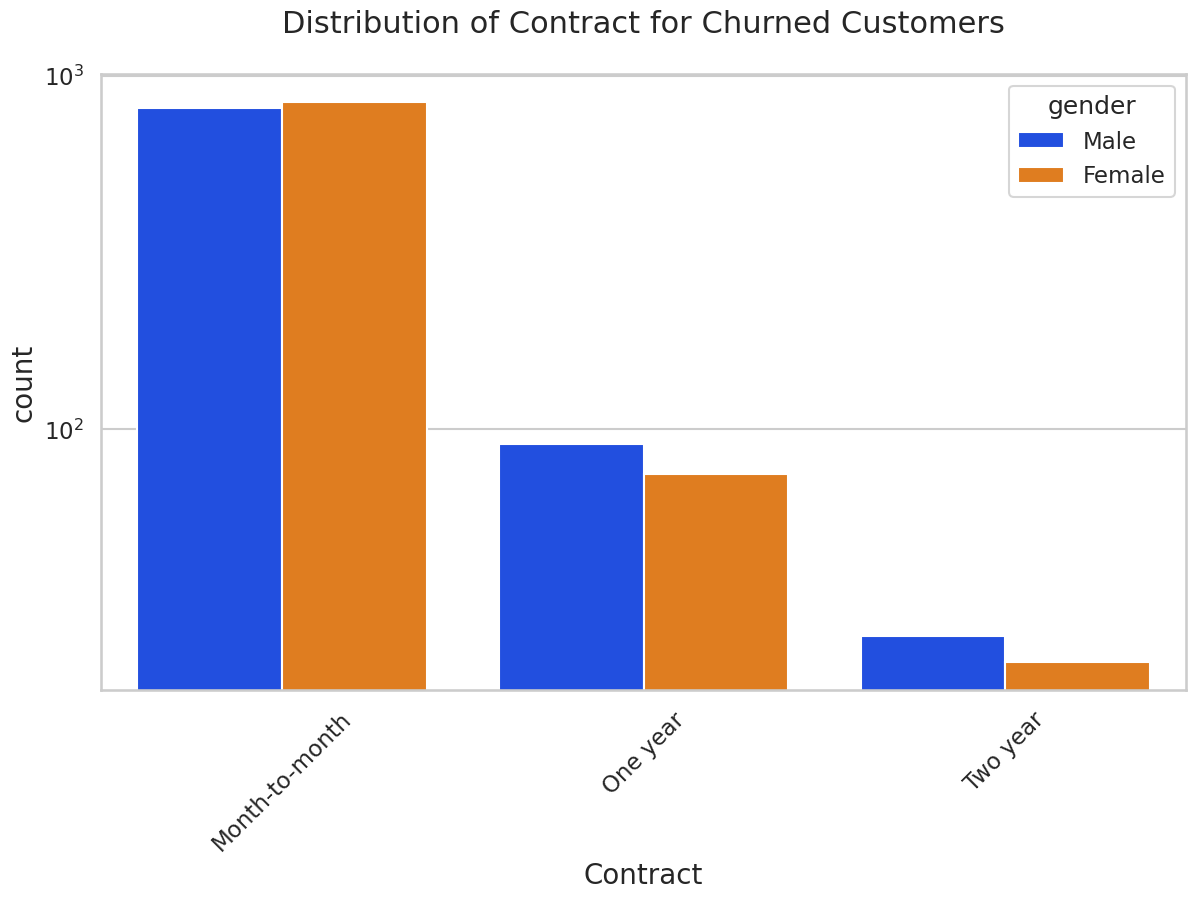

In [30]:
uniplot(new_df1_target1,col='Contract',title='Distribution of Contract for Churned Customers',hue='gender')

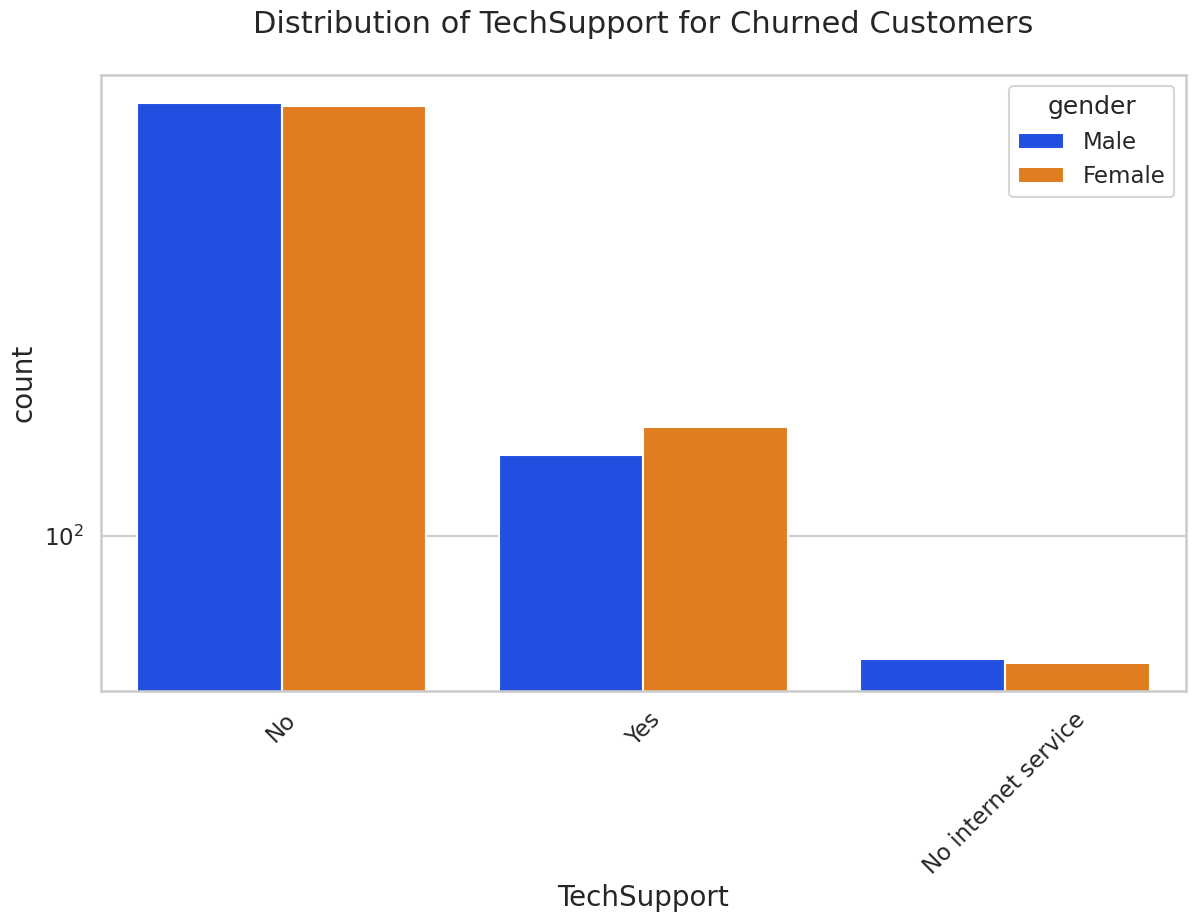

In [31]:
uniplot(new_df1_target1,col='TechSupport',title='Distribution of TechSupport for Churned Customers',hue='gender')

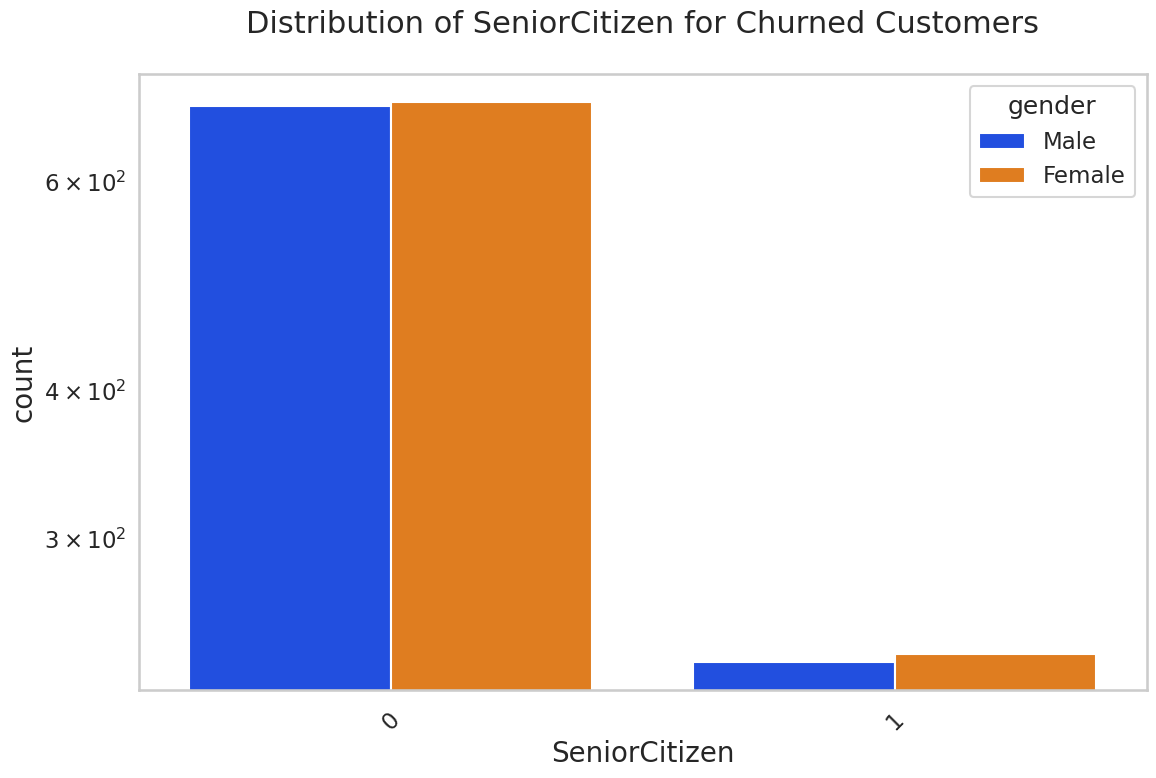

In [32]:
uniplot(new_df1_target1,col='SeniorCitizen',title='Distribution of SeniorCitizen for Churned Customers',hue='gender')

These are some of the quick insights from this exercise:

1. Electronic check medium are the highest churners
2. Contract Type - Monthly customers are more likely to churn because of no contract terms, as they are free to go customers.
3.  No Online security, No Tech Support category are high churners
4. Non senior Citizens are high churners <br>


# Data Preprocessing

In [33]:
df=telco_data_dummies
df.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,0,True,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
1,0,56.95,1889.50,0,False,True,True,False,True,False,...,False,False,False,True,False,False,True,False,False,False
2,0,53.85,108.15,1,False,True,True,False,True,False,...,False,False,False,True,True,False,False,False,False,False
3,0,42.30,1840.75,0,False,True,True,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4,0,70.70,151.65,1,True,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,False


In [34]:
x=df.drop('Churn',axis=1)
x

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29.85,29.85,True,False,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,False
1,0,56.95,1889.50,False,True,True,False,True,False,False,...,False,False,False,True,False,False,True,False,False,False
2,0,53.85,108.15,False,True,True,False,True,False,False,...,False,False,False,True,True,False,False,False,False,False
3,0,42.30,1840.75,False,True,True,False,True,False,True,...,True,False,False,False,False,False,False,True,False,False
4,0,70.70,151.65,True,False,True,False,True,False,False,...,False,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84.80,1990.50,False,True,False,True,False,True,False,...,False,False,False,True,False,True,False,False,False,False
7039,0,103.20,7362.90,True,False,False,True,False,True,False,...,False,True,False,False,False,False,False,False,False,True
7040,0,29.60,346.45,True,False,False,True,False,True,True,...,False,False,True,False,True,False,False,False,False,False
7041,1,74.40,306.60,False,True,False,True,True,False,False,...,False,False,False,True,True,False,False,False,False,False


In [35]:
y=df['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64

Train Test Split

In [36]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

# Model Training

1 Decision Tree Classifier

In [37]:
model_dt=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)
model_dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [38]:
y_pred=model_dt.predict(x_test)
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [39]:
model_dt.score(x_test,y_test)

0.7938877043354655

In [40]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1047
           1       0.61      0.55      0.58       360

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.79      0.79      0.79      1407



As we can see that the accuracy is okayish, and as it's an imbalanced dataset, we shouldn't consider Accuracy as our metrics to measure the model, as Accuracy is cursed in imbalanced datasets.
Hence, we need to check recall, precision & f1 score for the minority class, and it's quite evident that the precision, recall & f1 score is too low for Class 1, i.e. churned customers.
Hence, moving ahead to call SMOTEENN (UpSampling + ENN)

In [41]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(x, y)


In [42]:
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.2)

In [43]:
model_dt_smote=DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=6, min_samples_leaf=8)

In [44]:
model_dt_smote.fit(xr_train,yr_train)
yr_predict = model_dt_smote.predict(xr_test)
model_score_r = model_dt_smote.score(xr_test, yr_test)
print(model_score_r)
print(metrics.classification_report(yr_test, yr_predict))

0.916030534351145
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       514
           1       0.93      0.92      0.93       665

    accuracy                           0.92      1179
   macro avg       0.91      0.91      0.91      1179
weighted avg       0.92      0.92      0.92      1179



In [45]:
print(metrics.confusion_matrix(yr_test, yr_predict))

[[466  48]
 [ 51 614]]


Now we can see quite better results, i.e. Accuracy: 93 %, and a very good recall, precision & f1 score for minority class.
Let's try with some other classifier.

2 Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier
model_rf=RandomForestClassifier(n_estimators=100, criterion='gini', random_state = 100,max_depth=6, min_samples_leaf=8)
model_rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [47]:
y_pred=model_rf.predict(x_test)

In [48]:
model_rf.score(x_test,y_test)

0.798862828713575

In [49]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1047
           1       0.66      0.44      0.53       360

    accuracy                           0.80      1407
   macro avg       0.74      0.68      0.70      1407
weighted avg       0.78      0.80      0.78      1407



Overall, it seems the model performs better in predicting class 0 (higher precision, recall, and F1-score), but struggles more with class 1 predictions, especially in recall.

3 Neural networks (RNNs)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [51]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data to 3D tensor (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [52]:
# Define the model with L2 regularization
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', kernel_regularizer=l2(0.01), input_shape=(1, X_train.shape[2])))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7559 - loss: 0.9046 - val_accuracy: 0.7846 - val_loss: 0.6508
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8081 - loss: 0.5983 - val_accuracy: 0.7868 - val_loss: 0.5497
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8019 - loss: 0.5213 - val_accuracy: 0.7854 - val_loss: 0.5095
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8029 - loss: 0.4886 - val_accuracy: 0.7918 - val_loss: 0.4908
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8005 - loss: 0.4680 - val_accuracy: 0.7854 - val_loss: 0.4806
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8021 - loss: 0.4566 - val_accuracy: 0.7832 - val_loss: 0.4772
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8006 - loss: 0.4521 - val_accuracy: 0.7854 - val_loss: 0.4715
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8052 - loss: 0.4448 - val_accuracy: 0.

In [53]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7870 - loss: 0.4512
Test Loss: 0.45816680788993835, Test Accuracy: 0.7853589057922363


1. Epoch 1/20: Training accuracy of approximately 75.10% and training loss of approximately 0.937. Validation accuracy is around 78.54% with a validation loss of about 0.690.
2. Epoch 2/20: Training accuracy increases to about 80.87% with a decrease in training loss to about 0.628. Validation accuracy remains at 78.54%, and validation loss decreases to about 0.576.
3. Epochs 3-20: The model continues to train over the epochs, with fluctuating training and validation accuracy and loss. <br>
**Finally, after 20 epochs, your test accuracy is approximately 78.49%, with a test loss of about 0.453.**

# Evaluation

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


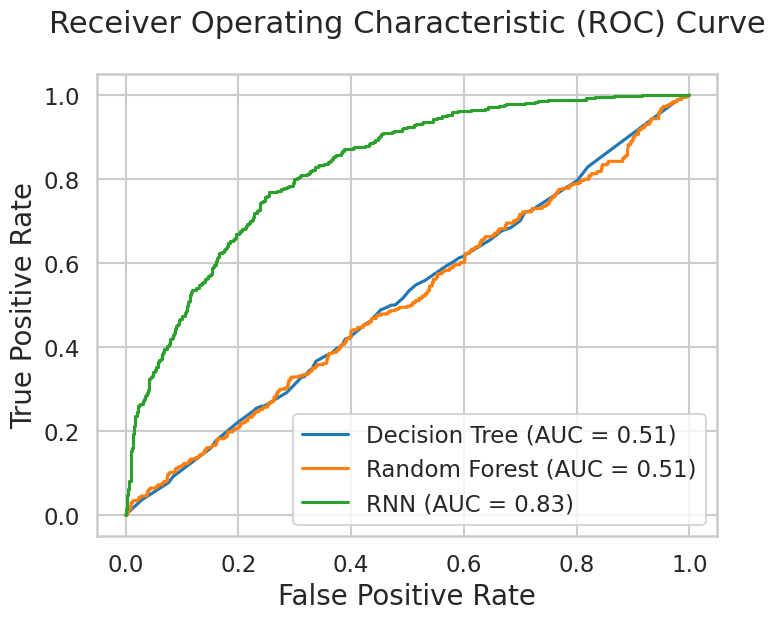

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve and AUC-ROC for model 1 (Decision Tree)
y_pred_prob_dt = model_dt.predict_proba(x_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
auc_dt = roc_auc_score(y_test, y_pred_prob_dt)

# Compute ROC curve and AUC-ROC for model 2 (Random Forest)
y_pred_prob_rf = model_rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Compute ROC curve and AUC-ROC for model 3 (RNN)
y_pred_prob_rnn = model.predict(X_test)
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, y_pred_prob_rnn)
auc_rnn = roc_auc_score(y_test, y_pred_prob_rnn)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = {:.2f})'.format(auc_dt))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(auc_rf))
plt.plot(fpr_rnn, tpr_rnn, label='RNN (AUC = {:.2f})'.format(auc_rnn))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1. AUC Values: The performance of each model is evaluated based on its Area Under the Curve (AUC) value. <br> The AUC value ranges from 0 to 1, where a model with an AUC of 1 is considered perfect, and a model with an AUC of 0.5 is considered as good as random guessing.
2. Decision Tree: The AUC for the Decision Tree model is 0.51, which is slightly better than random guessing.
3. Random Forest: The AUC for the Random Forest model is 0.50, which is equivalent to random guessing.
4. RNN: The AUC for the RNN model is 0.83, indicating a much better performance in classifying data compared to the other two models.
5. Best Model: Based on the AUC values, the RNN model appears to be the best model among the three for this particular task as it has the highest AUC value.